#**Pneumonia Detection on Chest_X-Ray using CNN and TFLite**
#**Table of contents**
**1-What is Pneumonia?**

**2-Import packages and libraries**

**3-Description of the Pneumonia Dataset**

**4-Load dataset from Kaggle**

**5-Explore the data (Understanding our data )**

**6-Setting Model Parameters**

**7-Data Augmentation**

**8-Using ImageDataGenerator to load images(Applying Data Augmentation )**

**9-Build model**

**10-Model summary**

**11-Model visualization**

**12-Train the model**

**13-Test our model (Accuracy and Confusion matrix)**

**14-Generate a SavedModel**

**15-Convert the SavedModel to TFLite**


#**What is Pneumonia?**

**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
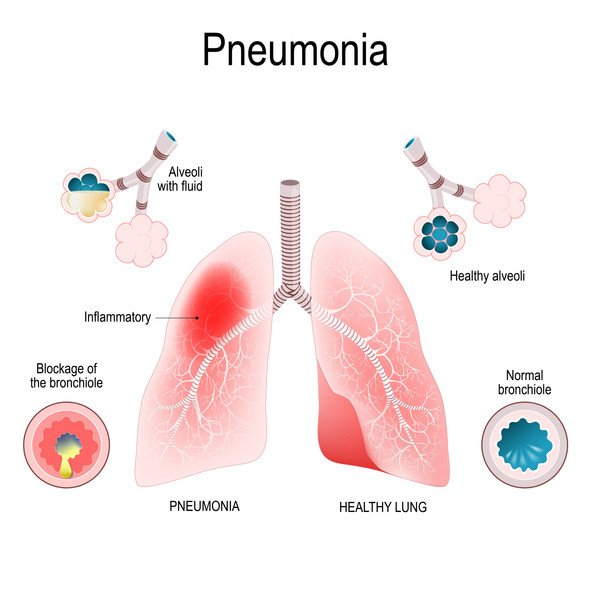

# **Import packages and libraries**

Importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [33]:
import os      
import numpy as np
import pandas as pd 
import cv2   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import random

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

sns.set(style='whitegrid', palette='muted', font_scale=1.4)
rcParams['figure.figsize'] = 14, 8


# Setting seeds for reproducibility
SEED = 548

def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

#**Description of the Pneumonia Dataset**

**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

# **Load dataset from Kaggle**

In [ ]:
! mkdir ~/.kaggle                 
from google.colab import files    
files.upload() 

In [ ]:
! cp kaggle.json ~/.kaggle/     
! chmod 600 ~/.kaggle/kaggle.json     
! kaggle datasets download paultimothymooney/chest-xray-pneumonia     

In [ ]:
!unzip chest-xray-pneumonia.zip

**The dataset we have downloaded has the following directory structur**e.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>NORMAL_and_PNEUMONIA_filtered</b>
|__ <b>train</b>
    |______ <b>NORMAL</b>: [NORMAL.0.jpeg, NORMAL.1.jpeg, NORMAL.2.jpeg ...]
    |______ <b>PNEUMONIA</b>: [PNEUMONIA3700.jpeg, PNEUMONIA3711.jpeg, PNEUMONIA372.2.jpeg ...]
|__ <b>val</b>
    |______ <b>NORMAL</b>: [NORMAL2000.jpeg, NORMAL.2001.jpeg, NORMAL.2002.jpeg ...]
    |______ <b>PNEUMONIA</b>: [PNEUMONIA2000.jpeg, PNEUMONIA.2001.jpeg, PNEUMONIA.2002.jpeg ...] 
|__ <b>test</b>
    |______ <b>NORMAL</b>: [NORMAL.0.jpeg, NORMAL.1.jpeg, NORMAL.2.jpeg ...]
    |______ <b>PNEUMONIA</b>: [PNEUMONIA.0.jpeg, PNEUMONIA.1.jpeg, PNEUMONIA.2.jpeg ...]
</pre>


# **Understanding our data**

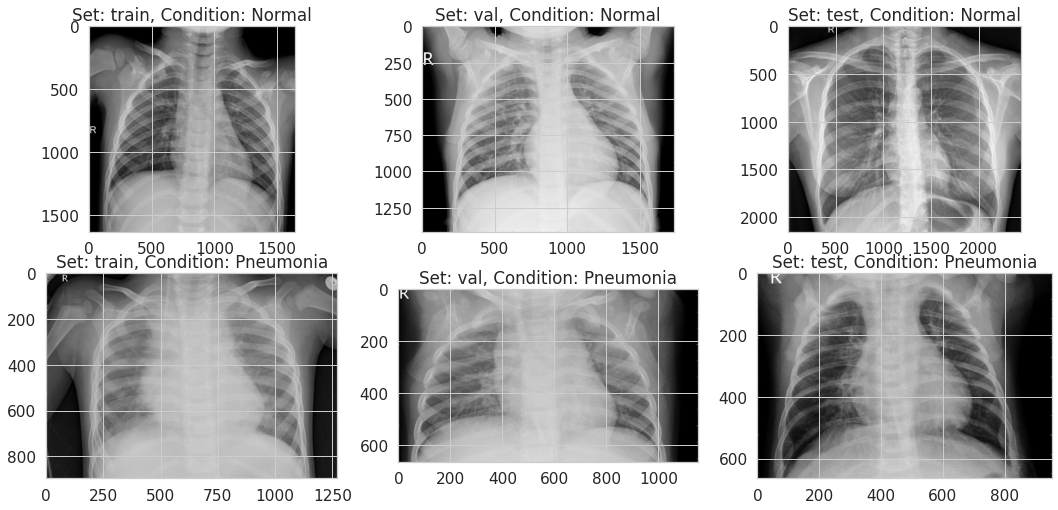

In [ ]:
input_path = 'chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

look at how many Normal and Pneumonia images we have in our training,validation and test directory

In [ ]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


# **Setting Model Parameters**

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [ ]:
# Hyperparameters
img_dims = 150    
batch_size = 32   

# **Data Augmentation** 

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# **Data Augmentation ( Flipping the image horizontally )**

We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation. This is achieved by passing horizontal_flip=True as an argument to the ImageDataGenerator class.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

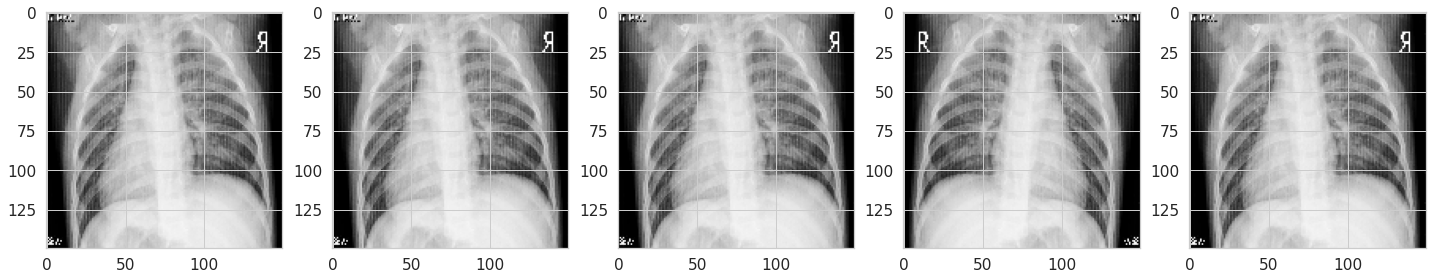

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Data Augmentation ( Rotating the image)**

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

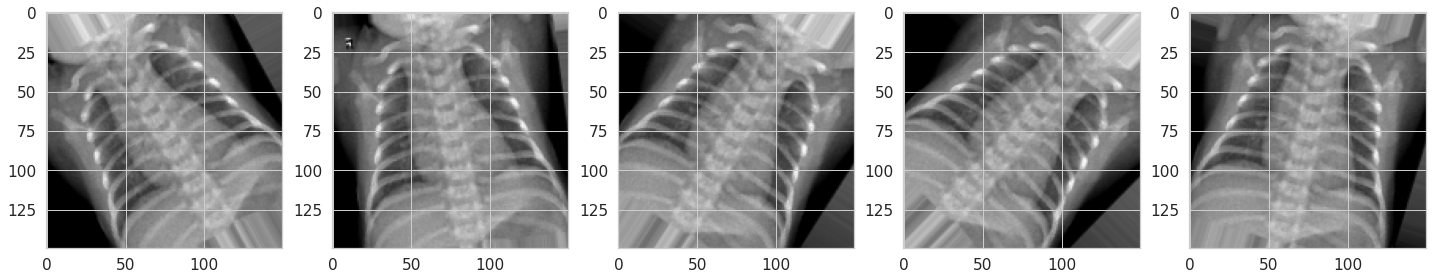

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Data Augmentation (Applying Zoom)**

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

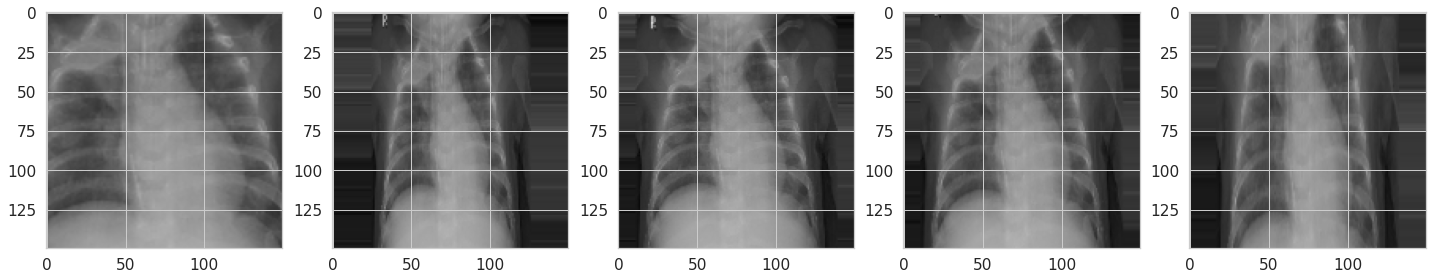

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Putting it all together (Data Augmentation)**

apply all these augmentations, and  others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
image_gen_train = ImageDataGenerator( 
rescale=1./255,
rotation_range=45,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest') 



train_gen = image_gen_train.flow_from_directory(
directory=input_path+'train', 
target_size=(img_dims, img_dims), 
batch_size=batch_size, 
class_mode='binary', 
shuffle=True)



Found 5216 images belonging to 2 classes.


visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset.

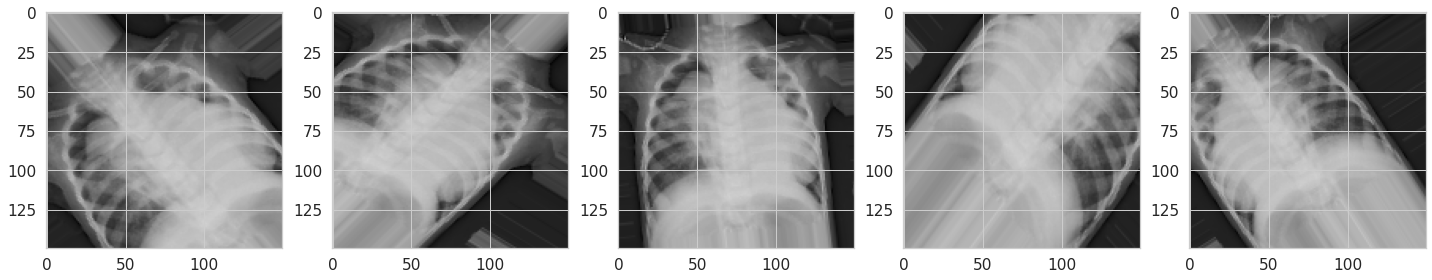

In [ ]:
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Using ImageDataGenerator (applying Data Augmentation )**

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
def process_data(img_dims, batch_size):
   
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    
   
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    seed=SEED,
    shuffle=True)

    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    seed=SEED,
    shuffle=True)
    
   
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Define the model**

In [ ]:
model = tf.keras.models.Sequential([
  
# First conv block
Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(img_dims, img_dims, 3)), 
Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
MaxPool2D(pool_size=(2, 2)),

# Second conv block
SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Third conv block
SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Fourth conv block
SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# Fifth conv block
SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),

# FC layer
Flatten(), 
Dense(units=512, activation='relu'),
Dropout(rate=0.7),
Dense(units=128, activation='relu'),
Dropout(rate=0.5),
Dense(units=64, activation='relu'),
Dropout(rate=0.3),


Dense(units=1, activation='sigmoid') 
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# **model summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344      
 leConv2D)                                                       
                                                        

# **model visualization**

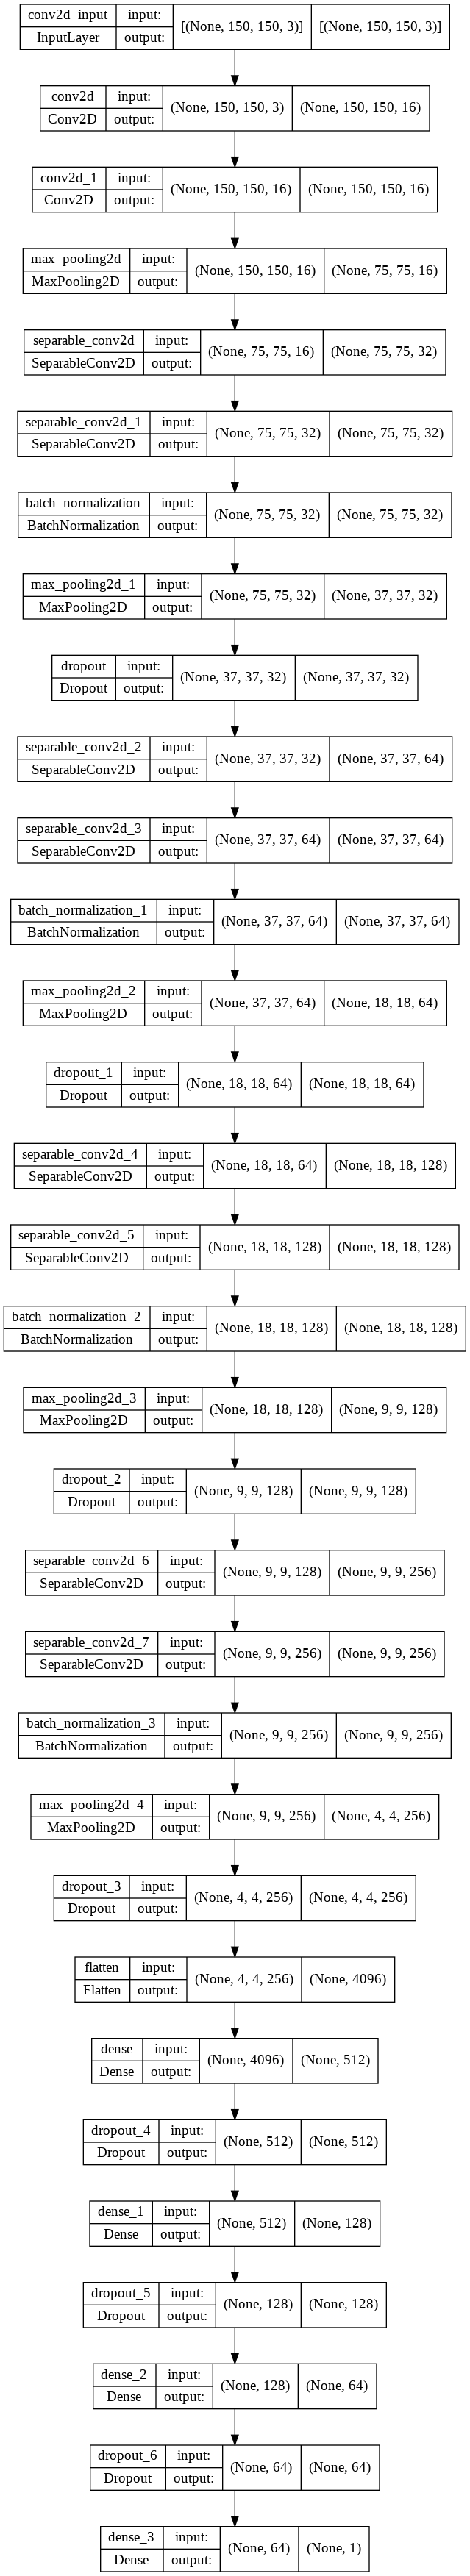

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file="pneumonia.png",show_shapes=True)

# **Fitting the model**

In [ ]:
epochs = 15

# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
163/163 [==============================] - 86s 502ms/step - loss: 0.3896 - accuracy: 0.8219 - val_loss: 1.2856 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 81s 499ms/step - loss: 0.2879 - accuracy: 0.8696 - val_loss: 1.2558 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 81s 500ms/step - loss: 0.2833 - accuracy: 0.8773 - val_loss: 1.5004 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 82s 500ms/step - loss: 0.2723 - accuracy: 0.8901 - val_loss: 0.5387 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 5/15
163/163 [==============================] - 82s 502ms/step - loss: 0.2496 - accuracy: 0.8997 - val_loss: 1.5120 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 6/15
163/163 [==============================] - 81s 498ms/step - loss: 0.2477 - accuracy: 0.9045 - val_loss: 1.8708 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 7/15
163/163 [==============================] 

# **Test our model => Accuracy and Confusion matrix**

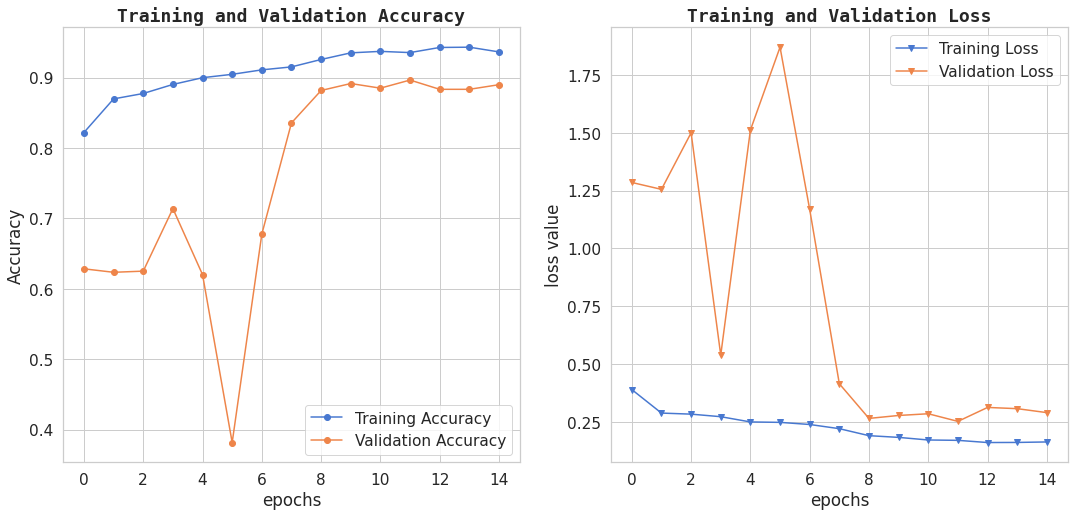

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'-o',label='Training Accuracy')
plt.plot(epochs_range, val_acc,'-o', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy',size=18,fontweight='bold',fontname='monospace')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,"-v",label='Training Loss')
plt.plot(epochs_range, val_loss,'-v',label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.title('Training and Validation Loss',size=18,fontweight='bold',fontname='monospace')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[177  57]
 [ 11 379]]

TEST METRICS ----------------------
Accuracy: 89.1025641025641%
Precision: 86.92660550458714%
Recall: 97.17948717948718%
F1-score: 91.76755447941888

TRAIN METRIC ----------------------
Train acc: 93.63


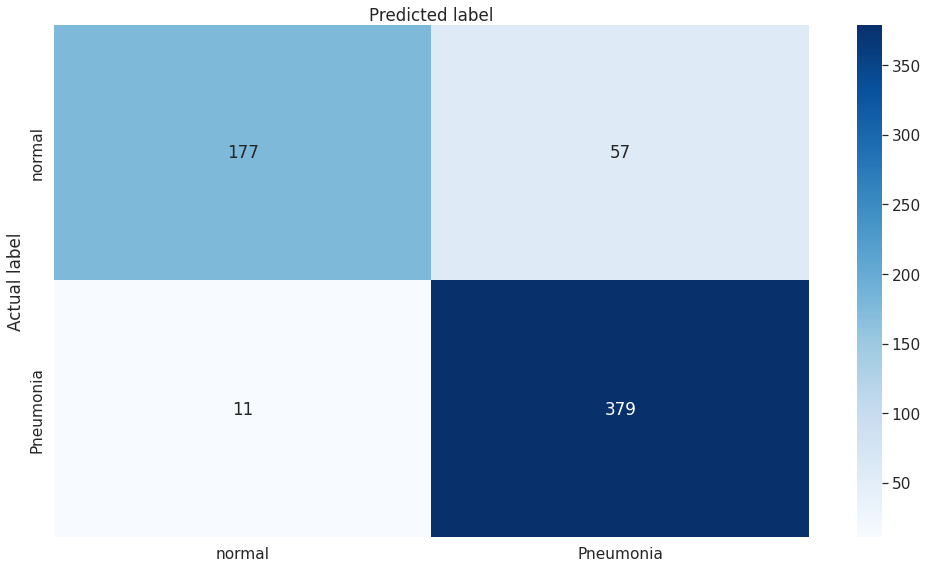

In [ ]:
class_names = ["normal","Pneumonia"]

fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names, )
sns.heatmap(df_cm,annot=True,cmap="Blues",fmt="d")
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# **Generate a SavedModel**

In [ ]:
export_dir = 'saved_model/Pneumonia'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/Pneumonia/assets


# **Convert the SavedModel to TFLite**

In [ ]:
import pathlib
tflite_model_name = "Pneumonia Detection(Chest_X-Ray).tflite"
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path(tflite_model_name)
tflite_model_file.write_bytes(tflite_model)

2376800

# **Download the TFLite model file**

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>